In [63]:
# Import full version of csvs, based on config.py
import pandas as pd
from random_access.configs import simulation_configs

# Import all csvs, based on config.py
dataframes = {}
for config in simulation_configs:
    label = config['label'].replace(' ', '_').lower()
    csv_file = f"csv/obss_simulation_{label}_simplified.csv"
    dataframes[label] = pd.read_csv(csv_file)

# Hitmap for channel utilization

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re

# 채널 utilization 계산 함수
def get_channel_utilization(label):
    df = dataframes[label]
    utilization = []
    for ch in ['0', '1']:
        backoff_condition = df[f'backoff_ch_{ch}'].apply(lambda x: ast.literal_eval(x).count(0) == 1)
        utilization.append(
            df[backoff_condition][f'channel_{ch}_occupied_until'].astype(bool).sum() / len(df)
        )
    return utilization


# 모든 label에 대해 utilization 수집
records = []
for label in dataframes.keys():
    util_ch0, util_ch1 = get_channel_utilization(label)

    match = re.match(r's(\d+)_(\d+)_f(short|long)_npca_(\d)', label)
    if match:
        ch0 = int(match.group(1))
        ch1 = int(match.group(2))
        frame = match.group(3)
        npca = int(match.group(4))  # ← npca 값을 정수로 추출

        records.append({
            "label": label,
            "ch0": ch0,
            "ch1": ch1,
            "frame": frame,
            "npca": npca,
            "util_ch0": util_ch0,
            "util_ch1": util_ch1
        })

df_util = pd.DataFrame(records)


In [65]:
plt.rcParams.update({
    "font.size": 24,           # 글꼴 크기
    "lines.linewidth": 2.5,    # 선 굵기 ← 이 줄 추가
    "lines.markersize": 8      # 마커 크기도 같이 조절 가능 (선택)
})

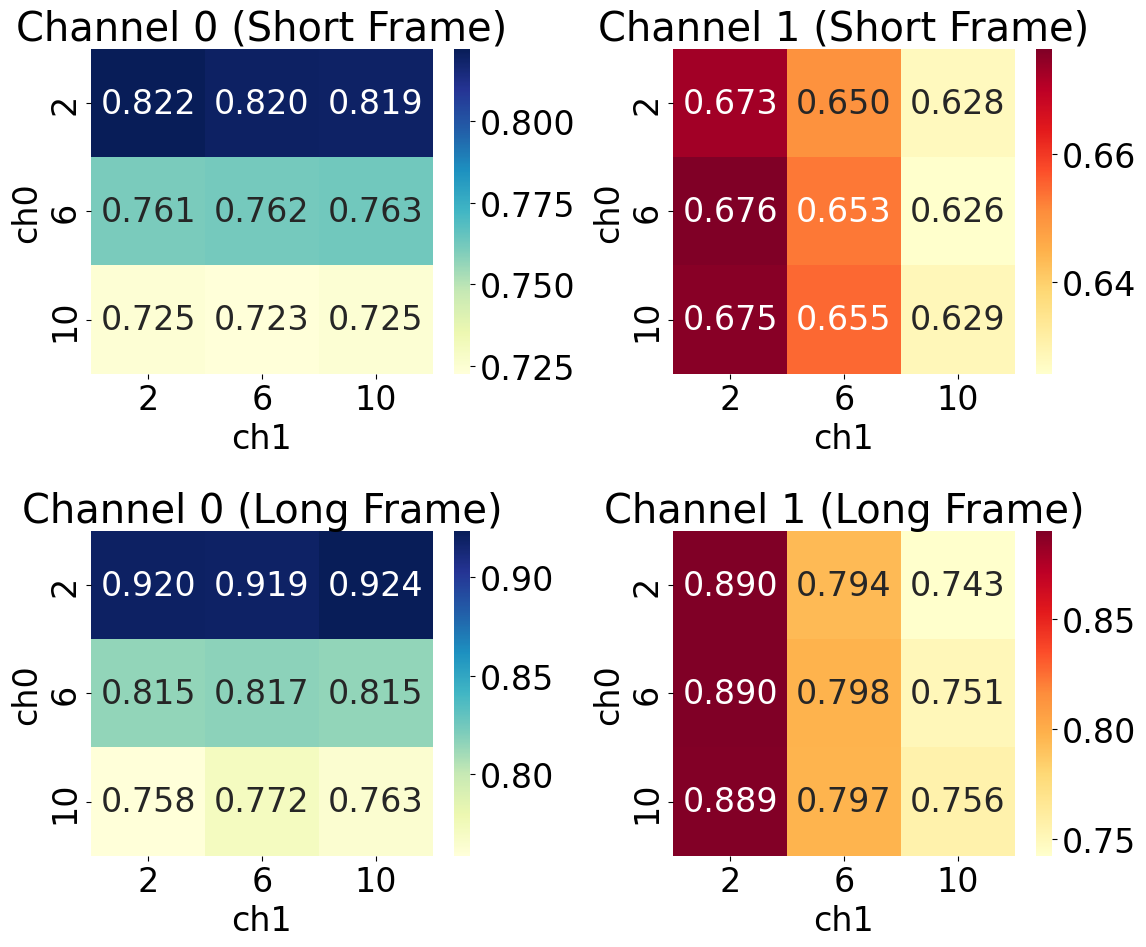

In [66]:

# NPCA OFF
df_short = df_util[(df_util["frame"] == "short") & (df_util["npca"] == 0)]
df_long = df_util[(df_util["frame"] == "long") & (df_util["npca"] == 0)]

pivot_ch0_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch1")
pivot_ch0_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch1")


# 히트맵 시각화
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pivot_ch0_short, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Short Frame)")

plt.subplot(2, 2, 2)
sns.heatmap(pivot_ch1_short, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Short Frame)")

plt.subplot(2, 2, 3)
sns.heatmap(pivot_ch0_long, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Long Frame)")

plt.subplot(2, 2, 4)
sns.heatmap(pivot_ch1_long, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Long Frame)")

plt.tight_layout()
plt.savefig("plots/npca_off_channel_utilization.eps")


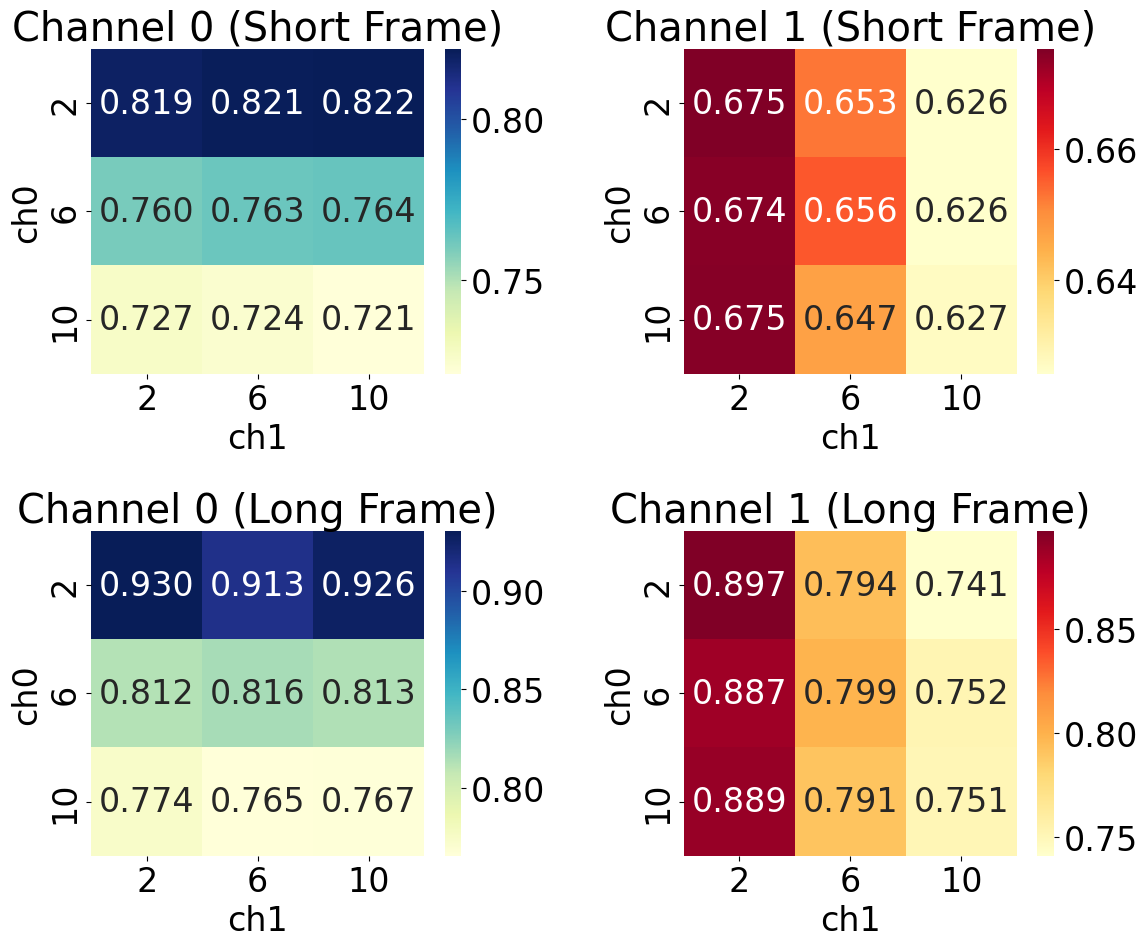

In [68]:
# NPCA ON
df_short = df_util[(df_util["frame"] == "short") & (df_util["npca"] == 1)]
df_long = df_util[(df_util["frame"] == "long") & (df_util["npca"] == 1)]

pivot_ch0_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch1")
pivot_ch0_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch1")


# 히트맵 시각화
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pivot_ch0_short, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Short Frame)")

plt.subplot(2, 2, 2)
sns.heatmap(pivot_ch1_short, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Short Frame)")

plt.subplot(2, 2, 3)
sns.heatmap(pivot_ch0_long, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Long Frame)")

plt.subplot(2, 2, 4)
sns.heatmap(pivot_ch1_long, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Long Frame)")

plt.tight_layout()
plt.savefig("plots/npca_on_channel_utilization.eps")


# Tput per each STA

In [69]:
import ast
from collections import Counter

def get_successful_stas(label, channel=0):
    df = dataframes[label]
    col_backoff = f'backoff_ch_{channel}'
    col_state = f'states_ch_{channel}'

    success_counter = Counter()
    
    for i, row in df.iterrows():
        backoffs = ast.literal_eval(row[col_backoff])
        states = ast.literal_eval(row[col_state])
        
        # 0이 정확히 하나일 경우
        if backoffs.count(0) == 1:
            idx = backoffs.index(0)
            if states[idx] == 'primary_transmitting':
                success_counter[idx] += 1

    # Throughput fraction 계산
    simulation_time = len(df)
    throughput = pd.Series(success_counter).sort_index() / simulation_time
    return throughput

def get_jain_index(label, channel=0):
    sta_tp = get_successful_stas(label, channel=channel)
    mean_tp = sta_tp.mean()
    
    # 제인 지수 계산
    if mean_tp == 0:
        return float('inf')  # 모든 STA가 실패한 경우
    else:
        return (sta_tp.sum())**2 / (len(sta_tp) * (sta_tp**2).sum())


In [ ]:
# # 출력
# for label in dataframes.keys():
#     for ch in [0, 1]:
#         fairness = []
#         sta_tp = get_successful_stas(label, channel=ch)
#         print(f"Channel {ch} STA Throughput (Success/μs) for {label}:")
#         print(sta_tp)
#         print()


: 

: 

In [ ]:
# print(get_jain_index('s2_2_fshort_npca_0', channel=0))
# print(get_jain_index('s2_2_fshort_npca_0', channel=1))

# 제인 지수 출력
# for label in dataframes.keys():
#     for ch in [0, 1]:
#         jain_index = get_jain_index(label, channel=ch)
#         print(f"Jain's Fairness Index for Channel {ch} in {label}: {jain_index:.4f}")

Jain's Fairness Index for Channel 0 in s2_2_fshort_npca_1: 1.0000
Jain's Fairness Index for Channel 1 in s2_2_fshort_npca_1: 1.0000


KeyboardInterrupt: 

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from collections import Counter
import os
from random_access.configs import simulation_configs

# # Step 1: 데이터프레임들 불러오기
# labels = [config["label"] for config in simulation_configs]
# dataframes = {
#     label: pd.read_csv(f"csv/obss_simulation_{label}.csv") for label in labels
# }


In [82]:
df = dataframes['s2_2_fshort_npca_0']
df

,time,slot,channel_0_occupied_until,channel_0_obss_occupied_until,states_ch_0,backoff_ch_0,channel_1_occupied_until,channel_1_obss_occupied_until,states_ch_1,backoff_ch_1
0,0,0,0,0,"['backoff', 'backoff']","[13, 13]",0,0,"['backoff', 'backoff']","[5, 5]"
1,9,1,0,0,"['backoff', 'backoff']","[12, 12]",0,0,"['backoff', 'backoff']","[4, 4]"
2,18,2,0,0,"['backoff', 'backoff']","[11, 11]",0,0,"['backoff', 'backoff']","[3, 3]"
3,27,3,0,0,"['backoff', 'backoff']","[10, 10]",0,0,"['backoff', 'backoff']","[2, 2]"
4,36,4,0,0,"['backoff', 'backoff']","[9, 9]",0,0,"['backoff', 'backoff']","[1, 1]"
...,...,...,...,...,...,...,...,...,...,...
999995,8999955,999995,31,0,"['backoff_frozen', 'primary_transmitting']","[4, 0]",5,0,"['backoff_frozen', 'primary_transmitting']","[10, 0]"
999996,8999964,999996,30,0,"['backoff_frozen', 'primary_transmitting']","[4, 0]",4,0,"['backoff_frozen', 'primary_transmitting']","[10, 0]"
999997,8999973,999997,29,0,"['backoff_frozen', 'primary_transmitting']","[4, 0]",3,0,"['backoff_frozen', 'primary_transmitting']","[10, 0]"
999998,8999982,999998,28,0,"['backoff_frozen', 'primary_transmitting']","[4, 0]",2,0,"['backoff_frozen', 'primary_transmitting']","[10, 0]"


In [83]:
df.head().to_csv("sample.csv", index=False)

In [84]:
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
from functools import partial
import gc

# 최적화된 성공 횟수 계산 함수
def get_successful_stas_optimized(df, channel=0):
    """
    벡터화된 연산을 사용하여 성공 횟수를 계산
    """
    col_backoff = f'backoff_ch_{channel}'
    col_state = f'states_ch_{channel}'
    
    success_counter = Counter()
    
    # 청크 단위로 처리하여 메모리 사용량 감소
    chunk_size = 10000
    total_rows = len(df)
    
    for start_idx in range(0, total_rows, chunk_size):
        end_idx = min(start_idx + chunk_size, total_rows)
        chunk = df.iloc[start_idx:end_idx]
        
        for _, row in chunk.iterrows():
            try:
                backoffs = ast.literal_eval(row[col_backoff])
                states = ast.literal_eval(row[col_state])
                
                # 0이 정확히 하나만 있는지 빠르게 체크
                zero_count = backoffs.count(0)
                if zero_count == 1:
                    idx = backoffs.index(0)
                    if idx < len(states) and states[idx] == 'primary_transmitting':
                        success_counter[idx] += 1
            except (ValueError, SyntaxError, IndexError):
                # 파싱 에러 무시
                continue
        
        # 메모리 정리
        if start_idx % (chunk_size * 10) == 0:
            gc.collect()
    
    return pd.Series(success_counter).sort_index()

def get_jain_index_optimized(df, channel=0):
    """
    최적화된 Jain 지수 계산
    """
    sta_tp = get_successful_stas_optimized(df, channel=channel)
    
    if len(sta_tp) == 0 or sta_tp.sum() == 0:
        return float('inf')
    
    # 넘파이 연산으로 최적화
    values = sta_tp.values
    n = len(values)
    sum_values = values.sum()
    sum_squares = (values ** 2).sum()
    
    return (sum_values ** 2) / (n * sum_squares)

def parse_label(label):
    """
    라벨 파싱 함수 (기존과 동일)
    """
    match = re.match(r's(\d+)_(\d+)_f(short|long)_npca_(\d+)', label)
    if match:
        return {
            "ch0": int(match.group(1)),
            "ch1": int(match.group(2)),
            "frame": match.group(3),
            "npca": int(match.group(4))
        }
    return None

def process_single_file(config):
    """
    단일 파일을 처리하는 함수 (멀티프로세싱용)
    """
    label = config['label'].replace(' ', '_').lower()
    csv_file = f"csv/obss_simulation_{label}_simplified.csv"
    
    try:
        # 청크 단위로 CSV 읽기
        df = pd.read_csv(csv_file, 
                        dtype={'time': 'int32', 'slot': 'int32'},
                        engine='c')  # C 엔진 사용으로 속도 향상
        
        meta = parse_label(label)
        if not meta:
            return []
        
        records = []
        for ch in [0, 1]:
            fairness = get_jain_index_optimized(df, channel=ch)
            records.append({
                "label": label,
                "ch0": meta["ch0"],
                "ch1": meta["ch1"],
                "frame": meta["frame"],
                "npca": meta["npca"],
                "channel": ch,
                "fairness": fairness
            })
        
        # 메모리 해제
        del df
        gc.collect()
        
        return records
        
    except Exception as e:
        print(f"Error processing {label}: {str(e)}")
        return []

def calculate_fairness_parallel(simulation_configs, max_workers=None):
    """
    병렬 처리를 통한 fairness 계산
    """
    if max_workers is None:
        max_workers = min(mp.cpu_count() - 1, len(simulation_configs))
    
    all_records = []
    
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # 작업 제출
        future_to_config = {
            executor.submit(process_single_file, config): config 
            for config in simulation_configs
        }
        
        # 결과 수집
        for future in as_completed(future_to_config):
            config = future_to_config[future]
            try:
                records = future.result()
                all_records.extend(records)
                print(f"Completed: {config['label']}")
            except Exception as e:
                print(f"Error with {config['label']}: {str(e)}")
    
    return pd.DataFrame(all_records)

def create_plots_optimized(df_fairness, output_dir="plots"):
    """
    최적화된 플롯 생성 함수
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    styles = {
        0: {"short": "dashed", "long": "dashdot"},
        1: {"short": "solid", "long": "dotted"},
    }
    
    unique_ch0_values = sorted(df_fairness["ch0"].unique())
    
    for ch0_val in unique_ch0_values:
        fig, ax = plt.subplots(figsize=(8, 3.5))
        
        for npca in [0, 1]:
            for frame in ["short", "long"]:
                subset = df_fairness[
                    (df_fairness["ch0"] == ch0_val) &
                    (df_fairness["channel"] == 0) &
                    (df_fairness["npca"] == npca) &
                    (df_fairness["frame"] == frame)
                ].sort_values("ch1")
                
                if not subset.empty:
                    label = f"npca={npca}, {frame}"
                    ax.plot(subset["ch1"], subset["fairness"],
                           label=label,
                           linestyle=styles[npca][frame],
                           marker='o')
        
        if len(df_fairness[df_fairness["ch0"] == ch0_val]) > 0:
            ch1_values = sorted(df_fairness[df_fairness["ch0"] == ch0_val]["ch1"].unique())
            ax.set_xticks(ch1_values)
        
        ax.set_title(f"Jain's Fairness Index on Channel 0\n(STA in ch0 = {ch0_val})")
        ax.set_xlabel("Number of STAs in Channel 1 (ch1)")
        ax.set_ylabel("Fairness Index (Channel 0)")
        ax.set_ylim(0.65, 1.01)
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/jain_fairness_ch0_{ch0_val}.png", dpi=150, bbox_inches='tight')
        plt.close()  # 메모리 절약을 위해 figure 닫기

# Jupyter Notebook용 실행 코드
def main_jupyter(use_parallel=True, max_workers=2):
    """
    Jupyter Notebook용 메인 실행 함수
    use_parallel: False로 설정하면 순차 처리
    max_workers: 병렬 처리 시 워커 수 (Jupyter에서는 2-4개 권장)
    """
    from random_access.configs import simulation_configs
    
    print(f"Processing {len(simulation_configs)} configurations...")
    
    if use_parallel:
        print(f"Using {max_workers} workers (parallel processing)")
        # Jupyter에서는 워커 수를 제한
        df_fairness = calculate_fairness_parallel(simulation_configs, max_workers=max_workers)
    else:
        print("Using sequential processing (safer for Jupyter)")
        df_fairness = calculate_fairness_sequential(simulation_configs)
    
    print(f"Calculated fairness for {len(df_fairness)} records")
    
    # 결과 저장
    df_fairness.to_csv("fairness_results.csv", index=False)
    print("Results saved to fairness_results.csv")
    
    # 플롯 생성
    create_plots_optimized(df_fairness)
    print("Plots saved to plots/ directory")
    
    return df_fairness

def calculate_fairness_sequential(simulation_configs):
    """
    순차 처리 버전 (Jupyter에서 더 안정적)
    """
    all_records = []
    total = len(simulation_configs)
    
    for i, config in enumerate(simulation_configs, 1):
        print(f"Processing {i}/{total}: {config['label']}")
        records = process_single_file(config)
        all_records.extend(records)
        
        # 진행률 표시
        if i % 5 == 0 or i == total:
            print(f"Completed {i}/{total} files")
    
    return pd.DataFrame(all_records)

# Jupyter Notebook에서 직접 실행 가능한 코드
def run_analysis(use_parallel=False, max_workers=2):
    """
    분석 실행 함수 - Jupyter에서 바로 호출 가능
    
    Parameters:
    - use_parallel: True면 병렬처리, False면 순차처리
    - max_workers: 병렬처리 시 워커 수 (2-4 권장)
    """
    try:
        return main_jupyter(use_parallel=use_parallel, max_workers=max_workers)
    except Exception as e:
        print(f"Error occurred: {e}")
        print("Try running with use_parallel=False for better stability")
        return None

# 추가 최적화 옵션들:

class MemoryEfficientProcessor:
    """
    메모리 효율적인 대용량 파일 처리 클래스
    """
    def __init__(self, chunk_size=50000):
        self.chunk_size = chunk_size
    
    def process_file_in_chunks(self, csv_file, channel=0):
        """
        파일을 청크 단위로 읽어서 처리
        """
        success_counter = Counter()
        col_backoff = f'backoff_ch_{channel}'
        col_state = f'states_ch_{channel}'
        
        # pandas chunksize 옵션 사용
        for chunk in pd.read_csv(csv_file, chunksize=self.chunk_size, engine='c'):
            for _, row in chunk.iterrows():
                try:
                    backoffs = ast.literal_eval(row[col_backoff])
                    states = ast.literal_eval(row[col_state])
                    
                    if backoffs.count(0) == 1:
                        idx = backoffs.index(0)
                        if idx < len(states) and states[idx] == 'primary_transmitting':
                            success_counter[idx] += 1
                except:
                    continue
            
            # 주기적으로 가비지 컬렉션
            gc.collect()
        
        return pd.Series(success_counter).sort_index()

# 사용 예시:
# processor = MemoryEfficientProcessor(chunk_size=100000)
# sta_tp = processor.process_file_in_chunks("large_file.csv", channel=0)

In [86]:
df_results = run_analysis(use_parallel=True, max_workers=4)  # 안전한 방법

Processing 36 configurations...
Using 4 workers (parallel processing)


Process SpawnProcess-1:
Process SpawnProcess-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/crazytb/miniconda/envs/random_access/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/crazytb/miniconda/envs/random_access/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/crazytb/miniconda/envs/random_access/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/crazytb/miniconda/envs/random_access/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/Users/crazytb/miniconda/envs/random_access/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/crazytb/miniconda/envs/random_access/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*s

Error with s2_2_fshort_npca_1: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_2_fshort_npca_0: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_2_flong_npca_1: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_2_flong_npca_0: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_6_fshort_npca_1: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_6_fshort_npca_0: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_6_flong_npca_1: A process in the process pool was terminated abruptly while the future was running or pending.
Error with s2_6_flong_npca_0: A process in the process pool was terminated abruptly while the future was running or pendi

In [ ]:
print(df_results.head())
print(f"Total records: {len(df_results)}")

In [71]:
# Step 2: 성공 횟수 계산 함수
def get_successful_stas(label, channel=0):
    df = dataframes[label]
    col_backoff = f'backoff_ch_{channel}'
    col_state = f'states_ch_{channel}'
    
    success_counter = Counter()
    
    for _, row in df.iterrows():
        backoffs = ast.literal_eval(row[col_backoff])
        states = ast.literal_eval(row[col_state])
        if backoffs.count(0) == 1:
            idx = backoffs.index(0)
            if states[idx] == 'primary_transmitting':
                success_counter[idx] += 1
    return pd.Series(success_counter).sort_index()

# Step 3: Jain 지수 계산
def get_jain_index(label, channel=0):
    sta_tp = get_successful_stas(label, channel=channel)
    mean_tp = sta_tp.mean()
    if mean_tp == 0:
        return float('inf')
    return (sta_tp.sum())**2 / (len(sta_tp) * (sta_tp**2).sum())

# Step 4: Label 파싱
def parse_label(label):
    match = re.match(r's(\d+)_(\d+)_f(short|long)_npca_(\d+)', label)
    if match:
        return {
            "ch0": int(match.group(1)),
            "ch1": int(match.group(2)),
            "frame": match.group(3),
            "npca": int(match.group(4))
        }

# Step 5: Jain 지수 수집
records = []
for label in dataframes:
    meta = parse_label(label)
    for ch in [0, 1]:
        fairness = get_jain_index(label, channel=ch)
        records.append({
            "label": label,
            "ch0": meta["ch0"],
            "ch1": meta["ch1"],
            "frame": meta["frame"],
            "npca": meta["npca"],
            "channel": ch,
            "fairness": fairness
        })
df_fairness = pd.DataFrame(records)

# Step 6: Plotting (Channel 0 기준)
colors = {2: 'blue', 6: 'green', 10: 'red'}
styles = {
    0: {"short": "dashed", "long": "dashdot"},
    1: {"short": "solid", "long": "dotted"},
}

# 유일한 ch0 값 목록
unique_ch0_values = sorted(df_fairness["ch0"].unique())


KeyboardInterrupt: 

In [ ]:
plt.rcParams.update({
    "font.size": 12,           # 글꼴 크기
    "lines.linewidth": 3,    # 선 굵기 ← 이 줄 추가
    "lines.markersize": 8      # 마커 크기도 같이 조절 가능 (선택)
})

: 

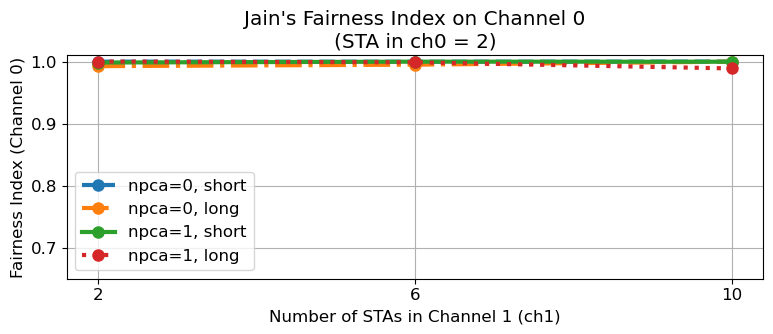

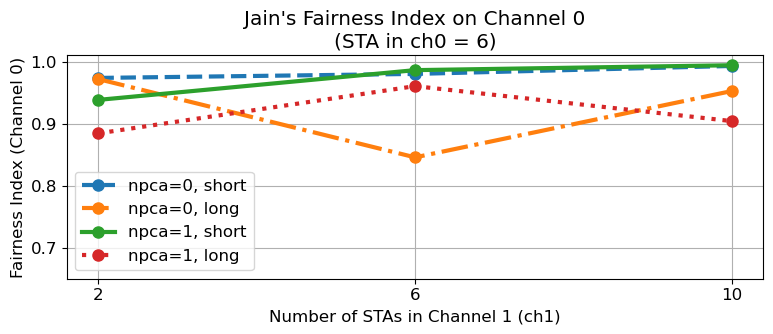

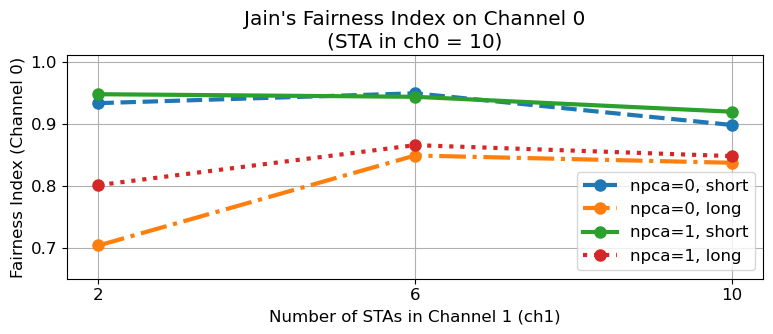

: 

In [ ]:

# 각 ch0 값에 대해 개별 plot 출력
for ch0_val in unique_ch0_values:
    fig, ax = plt.subplots(figsize=(8, 3.5))

    for npca in [0, 1]:
        for frame in ["short", "long"]:
            subset = df_fairness[
                (df_fairness["ch0"] == ch0_val) &
                (df_fairness["channel"] == 0) &
                (df_fairness["npca"] == npca) &
                (df_fairness["frame"] == frame)
            ].sort_values("ch1")
            if not subset.empty:
                label = f"npca={npca}, {frame}"
                ax.plot(subset["ch1"], subset["fairness"],
                        label=label,
                        linestyle=styles[npca][frame],
                        marker='o'
                        )
    ax.set_xticks(subset["ch1"].unique())
    ax.set_title(f"Jain's Fairness Index on Channel 0\n(STA in ch0 = {ch0_val})")
    ax.set_xlabel("Number of STAs in Channel 1 (ch1)")
    ax.set_ylabel("Fairness Index (Channel 0)")
    ax.set_ylim(0.65, 1.01)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"plots/jain_fairness_ch0_{ch0_val}.png")